# Visualize Monthly Corn Prices Using USDA NASS Data

This notebook creates time series plots of monthly corn prices, comparing nominal and real price trends from January 1953 to December 2024.

Click the badge below to open in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chuckgrigsby0/agec-370/blob/main/notebooks/11_plot_monthly_corn_prices.ipynb)

## Setup: Load Required Data

In [54]:
import pandas as pd
import numpy as np

# Load corn price data and CPI data directly from GitHub
base_url = "https://raw.githubusercontent.com/chuckgrigsby0/agec-370/main/data/"
corn_prices = pd.read_csv(base_url + 'corn_prices_year_and_monthly_nass.csv')
cpi = pd.read_csv(base_url + 'cpi_1913_2024.csv')

In [55]:
corn_prices.head()

,source_desc,sector_desc,group_desc,commodity_desc,statisticcat_desc,short_desc,domain_desc,class_desc,state_name,year,month,month_id,freq_desc,unit_desc,nominal_price
0,SURVEY,CROPS,FIELD CROPS,CORN,PRICE RECEIVED,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,ALL CLASSES,US TOTAL,2025,JAN,1,MONTHLY,$ / BU,4.29
1,SURVEY,CROPS,FIELD CROPS,CORN,PRICE RECEIVED,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,ALL CLASSES,US TOTAL,2025,FEB,2,MONTHLY,$ / BU,4.58
2,SURVEY,CROPS,FIELD CROPS,CORN,PRICE RECEIVED,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,ALL CLASSES,US TOTAL,2025,MAR,3,MONTHLY,$ / BU,4.57
3,SURVEY,CROPS,FIELD CROPS,CORN,PRICE RECEIVED,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,ALL CLASSES,US TOTAL,2025,APR,4,MONTHLY,$ / BU,4.62
4,SURVEY,CROPS,FIELD CROPS,CORN,PRICE RECEIVED,"CORN, GRAIN - PRICE RECEIVED, MEASURED IN $ / BU",TOTAL,ALL CLASSES,US TOTAL,2025,MAY,5,MONTHLY,$ / BU,4.64


In [56]:
## Data Preparation

# Separate monthly and annual (marketing year) observations
corn_prices_monthly = corn_prices.query("month != 'MARKETING YEAR'").copy()
corn_prices_annual = corn_prices.query("month == 'MARKETING YEAR'").copy()

### Create datetime index for time series plotting

In [57]:
# Create datetime column from year and month_id (format: YYYY-MM-01)
corn_prices_monthly['date'] = pd.to_datetime(
    corn_prices_monthly['year'].astype(str) + '-' + 
    corn_prices_monthly['month_id'].astype(str) + '-01'
)

# Sort by date for proper chronological ordering
corn_prices_monthly = corn_prices_monthly.sort_values('date').reset_index(drop=True)

# Verify datetime creation
print("First 5 observations:")
print(corn_prices_monthly[['year', 'month', 'month_id', 'date', 'nominal_price']].head())
print("\nLast 5 observations:")
print(corn_prices_monthly[['year', 'month', 'month_id', 'date', 'nominal_price']].tail())

First 5 observations:
   year month  month_id       date  nominal_price
0  1908   JAN         1 1908-01-01          0.550
1  1908   FEB         2 1908-02-01          0.570
2  1908   MAR         3 1908-03-01          0.596
3  1908   APR         4 1908-04-01          0.630
4  1908   MAY         5 1908-05-01          0.692

Last 5 observations:
      year month  month_id       date  nominal_price
1407  2025   APR         4 2025-04-01           4.62
1408  2025   MAY         5 2025-05-01           4.64
1409  2025   JUN         6 2025-06-01           4.47
1410  2025   JUL         7 2025-07-01           4.29
1411  2025   AUG         8 2025-08-01           3.96


### Calculate real (inflation-adjusted) prices

Formula: $P_{t, \text{real}} = P_{t, \text{nominal}} \times \frac{\text{CPI}_{\text{2024}}}{\text{CPI}_{t}}$

This adjusts all historical prices to 2024 purchasing power using annual CPI values.

In [58]:
# Merge CPI data with corn prices (same annual CPI applies to all months in that year)
corn_prices_monthly = corn_prices_monthly.merge(cpi, on='year', how='left')
corn_prices_annual = corn_prices_annual.merge(cpi, on='year', how='left')

In [59]:
# Get 2024 CPI as base year for inflation adjustment
cpi_base_year = cpi[cpi['year'] == 2024]['annual_avg_cpi'].values[0]
print(f"Base year (2024) CPI: {cpi_base_year}")

Base year (2024) CPI: 313.689


In [60]:
# Calculate real prices for monthly data
corn_prices_monthly['real_price'] = (
    corn_prices_monthly['nominal_price'] * (cpi_base_year / corn_prices_monthly['annual_avg_cpi'])
)

print("\nMonthly Price Summary Statistics:")
print(corn_prices_monthly[['nominal_price', 'real_price']].describe())


Monthly Price Summary Statistics:
       nominal_price   real_price
count    1412.000000  1344.000000
mean        1.960775    11.593790
std         1.428688     6.846647
min         0.188000     2.768916
25%         0.969500     5.682782
50%         1.470000    10.563418
75%         2.542500    15.598182
max         7.630000    45.582933


In [61]:
# Calculate real prices for annual data
corn_prices_annual['real_price'] = (
    corn_prices_annual['nominal_price'] * (cpi_base_year / corn_prices_annual['annual_avg_cpi'])
)

print("\nAnnual Price Summary Statistics:")
print(corn_prices_annual[['nominal_price', 'real_price']].describe())


Annual Price Summary Statistics:
       nominal_price  real_price
count     159.000000  112.000000
mean        1.534742   11.472844
std         1.369166    6.754626
min         0.214000    3.212381
25%         0.500500    5.809093
50%         1.080000   10.635870
75%         2.240000   14.826680
max         6.890000   34.064665


## Visualizations

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

### Annual price trends (marketing year)

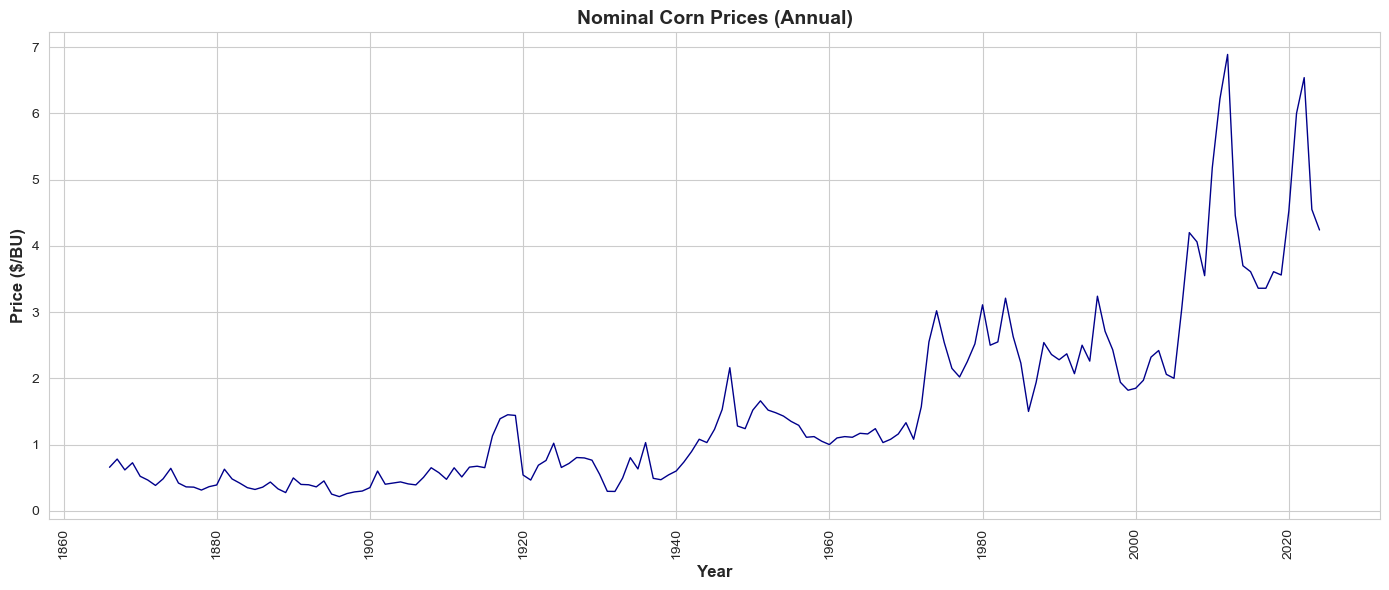

In [63]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=corn_prices_annual,
    x='year',
    y='nominal_price',
    linewidth=1.0,
    color='darkblue'
)

plt.title("Nominal Corn Prices (Annual)", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12, weight='bold')
plt.ylabel("Price ($/BU)", fontsize=12, weight='bold')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

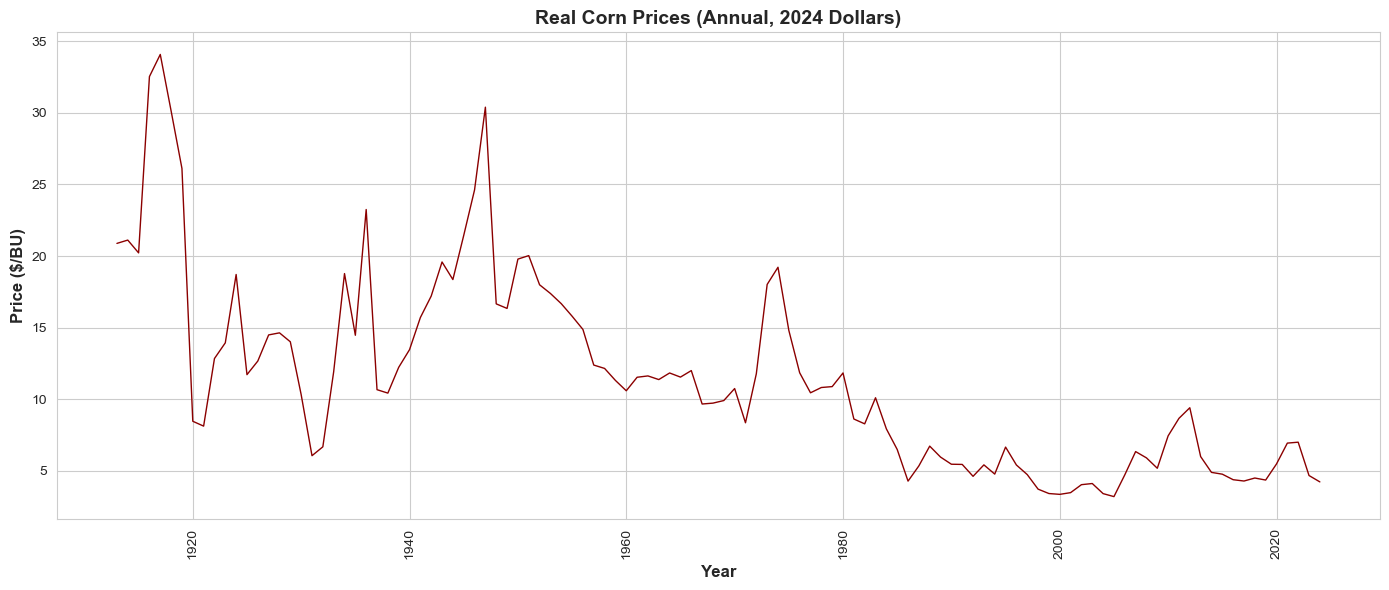

In [64]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=corn_prices_annual,
    x='year',
    y='real_price',
    linewidth=1.0,
    color='darkred'
)

plt.title("Real Corn Prices (Annual, 2024 Dollars)", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12, weight='bold')
plt.ylabel("Price ($/BU)", fontsize=12, weight='bold')
plt.xticks(rotation=90, ha='center')
plt.tight_layout()
plt.show()

### Seasonal patterns (2000-2024 average by month)

In [65]:
# Filter for 2000-2024 and calculate average prices by month
corn_prices_monthly_2000_2024 = corn_prices_monthly[corn_prices_monthly['year'].between(2000, 2024)]

avg_nominal_2000_2024 = corn_prices_monthly_2000_2024.groupby('month_id')['nominal_price'].mean().reset_index()
avg_real_2000_2024 = corn_prices_monthly_2000_2024.groupby('month_id')['real_price'].mean().reset_index()

In [66]:
# Add month labels to both datasets
unique_months = corn_prices_monthly[['month', 'month_id']].drop_duplicates().reset_index(drop=True)

avg_nominal_2000_2024 = avg_nominal_2000_2024.merge(unique_months, on='month_id', how='left')
avg_real_2000_2024 = avg_real_2000_2024.merge(unique_months, on='month_id', how='left')

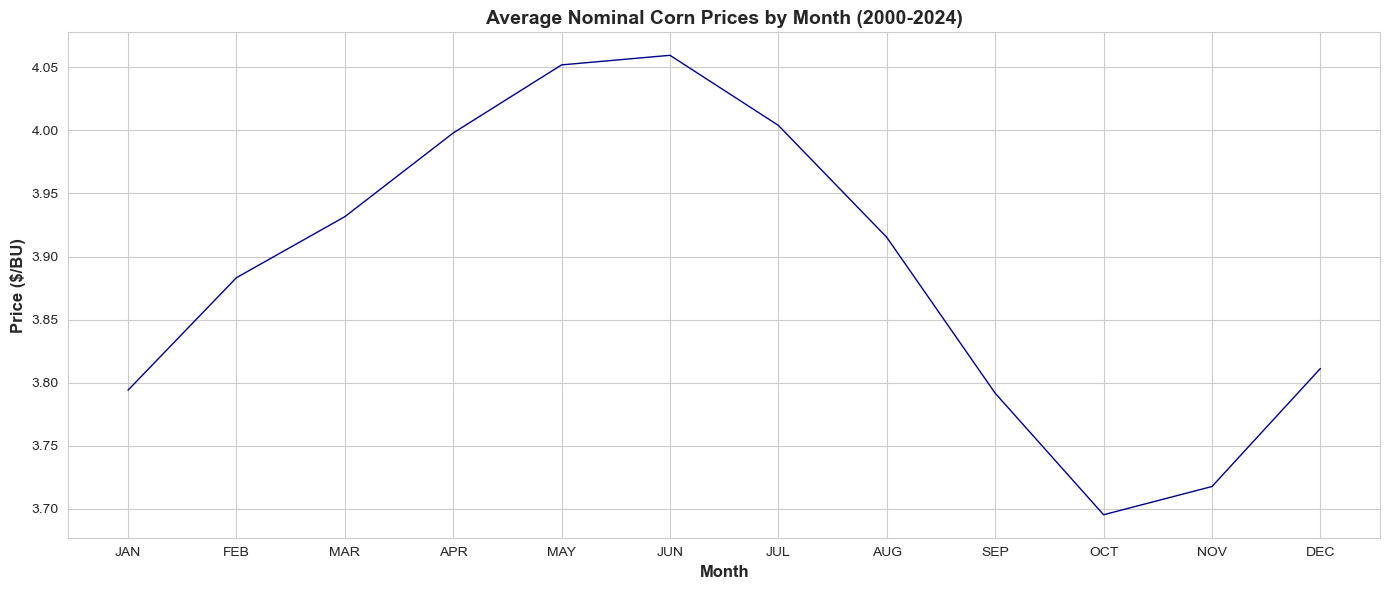

In [67]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=avg_nominal_2000_2024,
    x='month',
    y='nominal_price',
    linewidth=1.0,
    color='darkblue'
)

plt.title("Average Nominal Corn Prices by Month (2000-2024)", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12, weight='bold')
plt.ylabel("Price ($/BU)", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

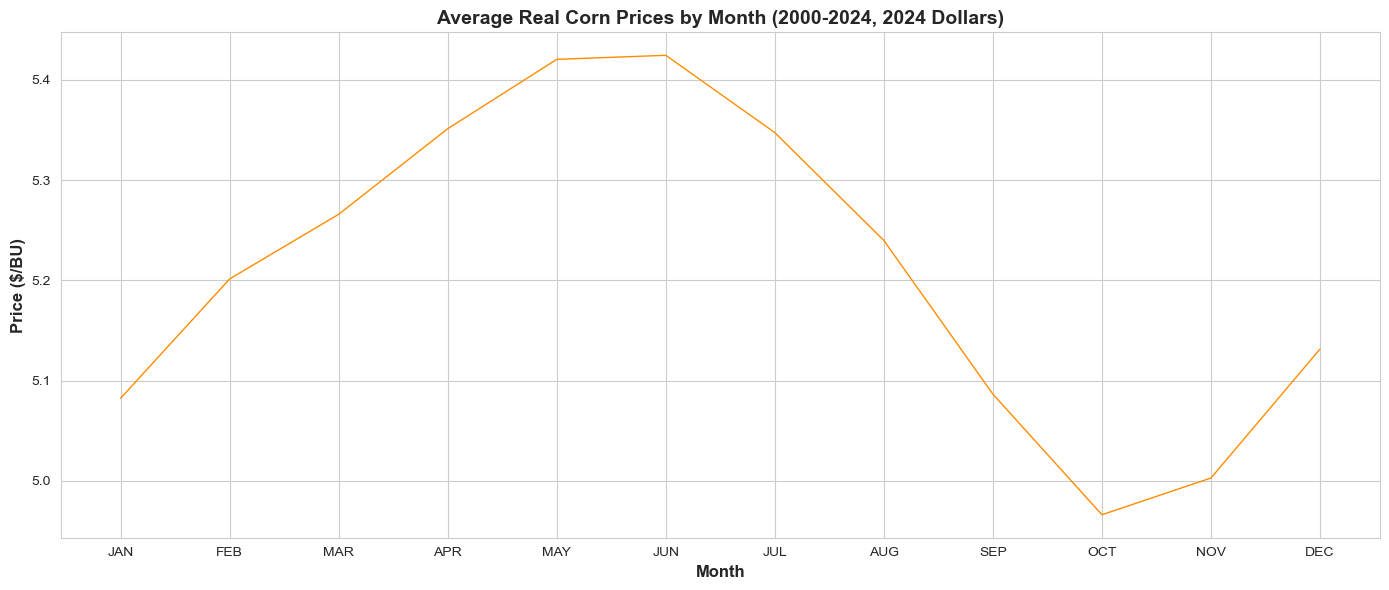

In [68]:
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=avg_real_2000_2024,
    x='month',
    y='real_price',
    linewidth=1.0,
    color='darkorange'
)

plt.title("Average Real Corn Prices by Month (2000-2024, 2024 Dollars)", fontsize=14, weight='bold')
plt.xlabel("Month", fontsize=12, weight='bold')
plt.ylabel("Price ($/BU)", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

### Historical monthly prices with regression trends

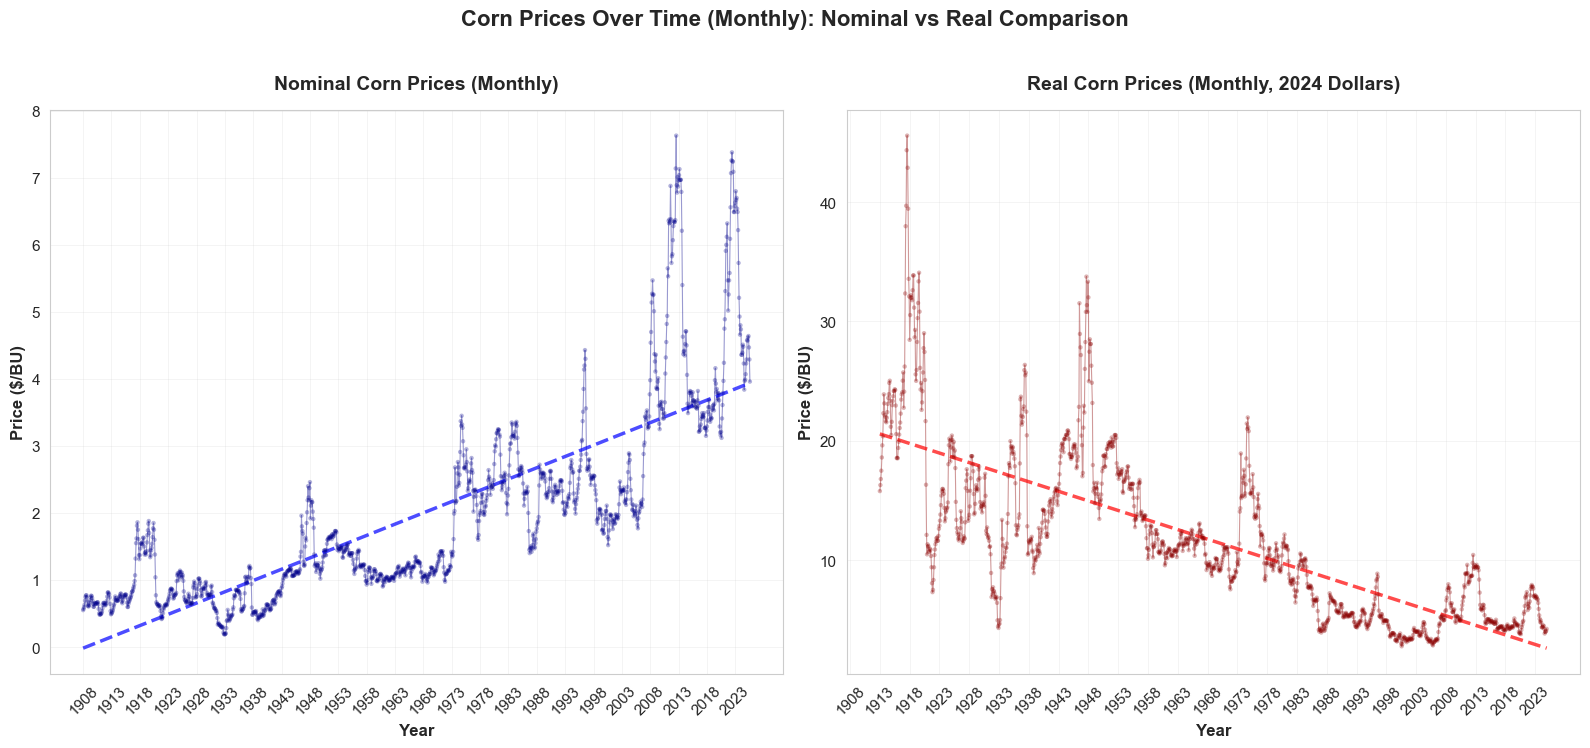

In [69]:
# Create side-by-side comparison of nominal and real prices with regression lines
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Convert datetime to numeric for regression analysis
corn_prices_monthly['date_numeric'] = (
    corn_prices_monthly['date'] - corn_prices_monthly['date'].min()
).dt.days

# Generate year labels for x-axis (every 5 years)
years_to_show = range(corn_prices_monthly['year'].min(), corn_prices_monthly['year'].max() + 1, 5)
tick_positions = []
tick_labels = []

for year in years_to_show:
    year_data = corn_prices_monthly[corn_prices_monthly['year'] == year]
    if not year_data.empty:
        tick_positions.append(year_data['date_numeric'].iloc[0])
        tick_labels.append(str(year))

# ============================================================
# LEFT PLOT: NOMINAL PRICES
# ============================================================

sns.regplot(
    data=corn_prices_monthly,
    x='date_numeric',
    y='nominal_price',
    scatter_kws={
        'alpha': 0.3,
        's': 10,
        'color': 'darkblue',
        'edgecolors': 'none',
        'zorder': 3
    },
    line_kws={
        'color': 'blue',
        'linewidth': 2.5,
        'linestyle': '--',
        'alpha': 0.7,
        'zorder': 2
    },
    ci=None,
    ax=axes[0]
)

# Add connecting line for temporal continuity
axes[0].plot(
    corn_prices_monthly['date_numeric'],
    corn_prices_monthly['nominal_price'],
    color='darkblue',
    linewidth=0.8,
    alpha=0.4,
    zorder=1
)

axes[0].set_title('Nominal Corn Prices (Monthly)', fontsize=14, weight='bold', pad=15)
axes[0].set_xlabel('Year', fontsize=12, weight='bold')
axes[0].set_ylabel('Price ($/BU)', fontsize=12, weight='bold')
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels)
axes[0].tick_params(axis='both', labelsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='both', alpha=0.3, linestyle='-', linewidth=0.5)

# ============================================================
# RIGHT PLOT: REAL PRICES
# ============================================================

sns.regplot(
    data=corn_prices_monthly,
    x='date_numeric',
    y='real_price',
    scatter_kws={
        'alpha': 0.3,
        's': 10,
        'color': 'darkred',
        'edgecolors': 'none',
        'zorder': 3
    },
    line_kws={
        'color': 'red',
        'linewidth': 2.5,
        'linestyle': '--',
        'alpha': 0.7,
        'zorder': 2
    },
    ci=None,
    ax=axes[1]
)

# Add connecting line for temporal continuity
axes[1].plot(
    corn_prices_monthly['date_numeric'],
    corn_prices_monthly['real_price'],
    color='darkred',
    linewidth=0.8,
    alpha=0.4,
    zorder=1
)

axes[1].set_title('Real Corn Prices (Monthly, 2024 Dollars)', fontsize=14, weight='bold', pad=15)
axes[1].set_xlabel('Year', fontsize=12, weight='bold')
axes[1].set_ylabel('Price ($/BU)', fontsize=12, weight='bold')
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)
axes[1].tick_params(axis='both', labelsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='both', alpha=0.3, linestyle='-', linewidth=0.5)

# Add overall title
fig.suptitle(
    'Corn Prices Over Time (Monthly): Nominal vs Real Comparison',
    fontsize=16,
    weight='bold',
    y=0.98
)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()